### A Convolutional Neural Network

In [67]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_DIR = os.path.join("data", "train")
TEST_DIR = os.path.join("data", "test")

In [3]:
print(f"Train Directory is {len(os.listdir(TRAIN_DIR))}")
print(f"Test Images is {len(os.listdir(TEST_DIR))}")

Train Directory is 5
Test Images is 924


#### Convert to RGB check

In [4]:
class ConvertToRgb(object):
    """Convert a PIL image to RGB mode."""
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

In [5]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [6]:
def get_mean_std(data_dir):
    """
    Calculates the mean and standard deviation for a dataset.
    """

    simple_transform = transforms.Compose([
        ConvertToRgb(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=simple_transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    
    num_samples = 0.
    mean = torch.zeros(3)
    std = torch.zeros(3)
    
    print("Calculating mean and std...")
    for images, _ in loader:
        batch_size = images.size(0)
        num_samples += batch_size
        
        # Reshape images to (3, -1) and calculate the mean for each channel
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        
    mean /= num_samples
    std /= num_samples
    
    print(f"Calculated Mean: {mean}")
    print(f"Calculated Std: {std}")
    return mean, std


In [7]:
calc_mean, calc_std = get_mean_std(TRAIN_DIR)

Calculating mean and std...
Calculated Mean: tensor([0.5028, 0.4439, 0.3137])
Calculated Std: tensor([0.2437, 0.2187, 0.2224])


In [8]:
transform_norm = transforms.Compose([
  ConvertToRgb(),
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=calc_mean, std=calc_std)
])

In [9]:
g = torch.Generator()
g.manual_seed(42)

full_train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform_norm)

In [10]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

print(f"Train size {train_size} and val size {val_size}")

Train size 2196 and val size 550


In [11]:
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=g)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Building the Model

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

I am using a pretrained model because the model is likely to overfit on the smaller training data.

In [13]:
for params in model.parameters():
  params.requires_grad = False

In [14]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 5) 
)

## Training the model

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [34]:
model.to(device=device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

In [17]:
for epoch in range(NUM_EPOCHS):
    # ---- TRAINING ----
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}] Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        # Stats
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_corrects / total

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_corrects, val_total = 0.0, 0, 0

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}] Validation", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)

            loop.set_postfix(loss=loss.item())

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_corrects / val_total

    # Save history
    history["train_loss"].append(epoch_train_loss)
    history["train_acc"].append(epoch_train_acc)
    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} "
        f"| Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} "
        f"| Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}"
    )

Epoch [1/10] Training:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.8129 Acc: 0.7013 | Val Loss: 0.5383 Acc: 0.8055


Epoch 2/10 | Train Loss: 0.4261 Acc: 0.8497 | Val Loss: 0.4188 Acc: 0.8673


Epoch 3/10 | Train Loss: 0.3781 Acc: 0.8638 | Val Loss: 0.3923 Acc: 0.8618


Epoch 4/10 | Train Loss: 0.3191 Acc: 0.8880 | Val Loss: 0.3648 Acc: 0.8745


Epoch 5/10 | Train Loss: 0.3010 Acc: 0.8912 | Val Loss: 0.3841 Acc: 0.8618


Epoch 6/10 | Train Loss: 0.2641 Acc: 0.9026 | Val Loss: 0.3473 Acc: 0.8655


Epoch 7/10 | Train Loss: 0.2644 Acc: 0.9080 | Val Loss: 0.3704 Acc: 0.8691


Epoch 8/10 | Train Loss: 0.2495 Acc: 0.9039 | Val Loss: 0.3758 Acc: 0.8691


Epoch 9/10 | Train Loss: 0.2818 Acc: 0.8985 | Val Loss: 0.3447 Acc: 0.8782


Epoch 10/10 | Train Loss: 0.2059 Acc: 0.9267 | Val Loss: 0.3693 Acc: 0.8764


In [18]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # Loss curve
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    # Accuracy curve
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.show()


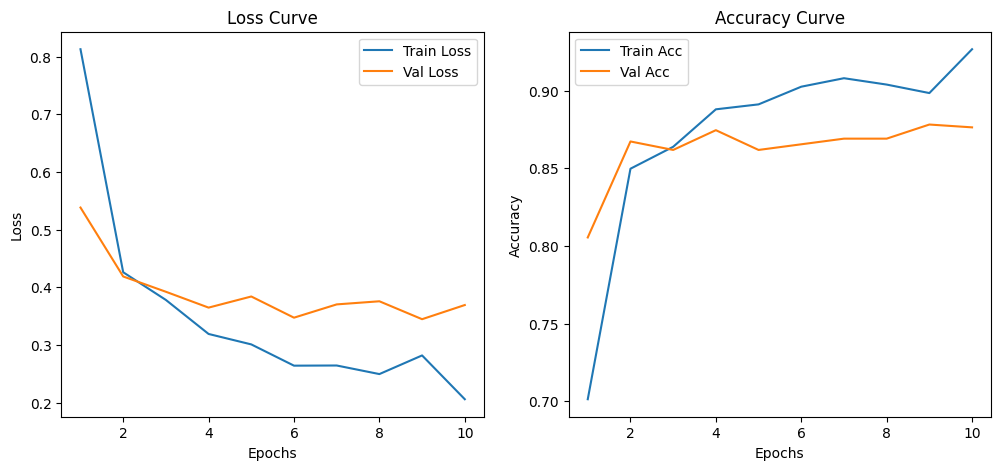

In [19]:
plot_history(history)

In [21]:
history

{'train_loss': [0.812922438420016,
  0.4261202468029571,
  0.37807295923350287,
  0.3190848717706885,
  0.3009689610946808,
  0.264103673493493,
  0.26439155944926707,
  0.24951302234375194,
  0.2818472580831559,
  0.2059024819096581],
 'train_acc': [0.7012750455373407,
  0.8497267759562842,
  0.8638433515482696,
  0.8879781420765027,
  0.8911657559198543,
  0.9025500910746812,
  0.9080145719489982,
  0.9039162112932605,
  0.8984517304189436,
  0.9266848816029144],
 'val_loss': [0.5383383647420189,
  0.41878980268131605,
  0.3922700970010324,
  0.36478392852978275,
  0.38407507701353594,
  0.3473312371698293,
  0.3703658437457952,
  0.3757632513513619,
  0.344701052904129,
  0.36925998059186066],
 'val_acc': [0.8054545454545454,
  0.8672727272727273,
  0.8618181818181818,
  0.8745454545454545,
  0.8618181818181818,
  0.8654545454545455,
  0.8690909090909091,
  0.8690909090909091,
  0.8781818181818182,
  0.8763636363636363]}

In [22]:
def save_model(model, path="model.pth"):
    torch.save(model, path)
    print(f"Model saved to {path}")


save_model(model)

Model saved to model.pth


In [31]:
def evaluate_model(model, val_loader, device, class_names=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Metrics
    acc = (torch.tensor(y_true) == torch.tensor(y_pred)).float().mean().item()
    print(f"Validation Accuracy: {acc:.4f}")

    if class_names:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    return acc, y_pred, y_true

In [32]:
class_names = train_dataset.dataset.classes

val_acc, y_pred, y_true = evaluate_model(model, val_loader, device, class_names)

100%|██████████| 18/18 [00:59<00:00,  3.31s/it]

Validation Accuracy: 0.8764

Classification Report:
              precision    recall  f1-score   support

       daisy       0.89      0.91      0.90       107
   dandelion       0.89      0.94      0.91       113
        rose       0.85      0.77      0.81        87
   sunflower       0.95      0.89      0.91        97
       tulip       0.83      0.86      0.85       146

    accuracy                           0.88       550
   macro avg       0.88      0.87      0.88       550
weighted avg       0.88      0.88      0.88       550


Confusion Matrix:
[[ 97   4   1   1   4]
 [  3 106   0   2   2]
 [  1   1  67   0  18]
 [  3   5   1  86   2]
 [  5   3  10   2 126]]


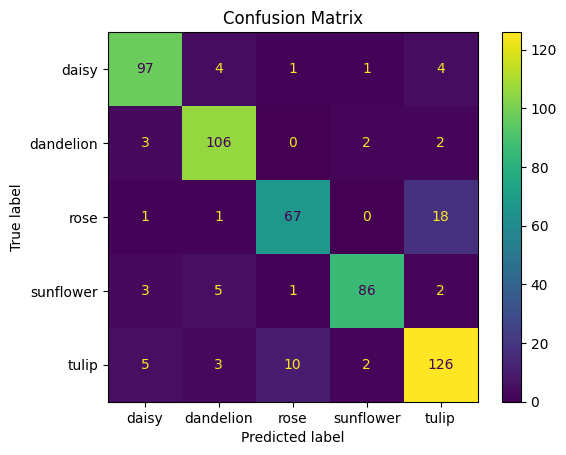

In [34]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [38]:

def predict_on_test(model, test_dir, class_names, device="cpu"):
    transform = transforms.Compose([
        ConvertToRgb(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=calc_mean, std=calc_std)
    ])
    
    results = []
    
    with torch.no_grad():
        for filename in tqdm(os.listdir(test_dir)):
            file_path = os.path.join(test_dir, filename)
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue 

            # Load and preprocess
            img = Image.open(file_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Prediction
            outputs = model(img_tensor)
            _, pred = torch.max(outputs, 1)
            predicted_class = class_names[pred.item()]

            results.append({"filename": filename, "prediction": predicted_class})
    
    # To a DataFrame

    df = pd.DataFrame(results)
    
    return df

In [39]:
df = predict_on_test(model, TEST_DIR, class_names, device)
df.head()

100%|██████████| 924/924 [02:55<00:00,  5.27it/s]


,filename,prediction
0,Image_1.jpg,sunflower
1,Image_10.jpg,dandelion
2,Image_100.jpg,daisy
3,Image_101.jpg,sunflower
4,Image_102.jpg,daisy


In [40]:
df.head(10)

,filename,prediction
0,Image_1.jpg,sunflower
1,Image_10.jpg,dandelion
2,Image_100.jpg,daisy
3,Image_101.jpg,sunflower
4,Image_102.jpg,daisy
5,Image_103.jpg,daisy
6,Image_104.jpg,tulip
7,Image_105.jpg,tulip
8,Image_106.jpg,dandelion
9,Image_107.jpg,sunflower


In [68]:
def show_predictions(df, test_dir="data/test", num_images=6):
    samples = df.head(num_images)

    plt.figure(figsize=(15, 8))

    for i, (filename, prediction) in enumerate(zip(samples["filename"], samples["prediction"])):
        img_path = Path(test_dir) / filename
        img = Image.open(img_path).convert("RGB")

        # subplot
        plt.subplot(2, (num_images + 1)//2, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {prediction}", fontsize=12, color="green")

    plt.tight_layout()
    plt.show()

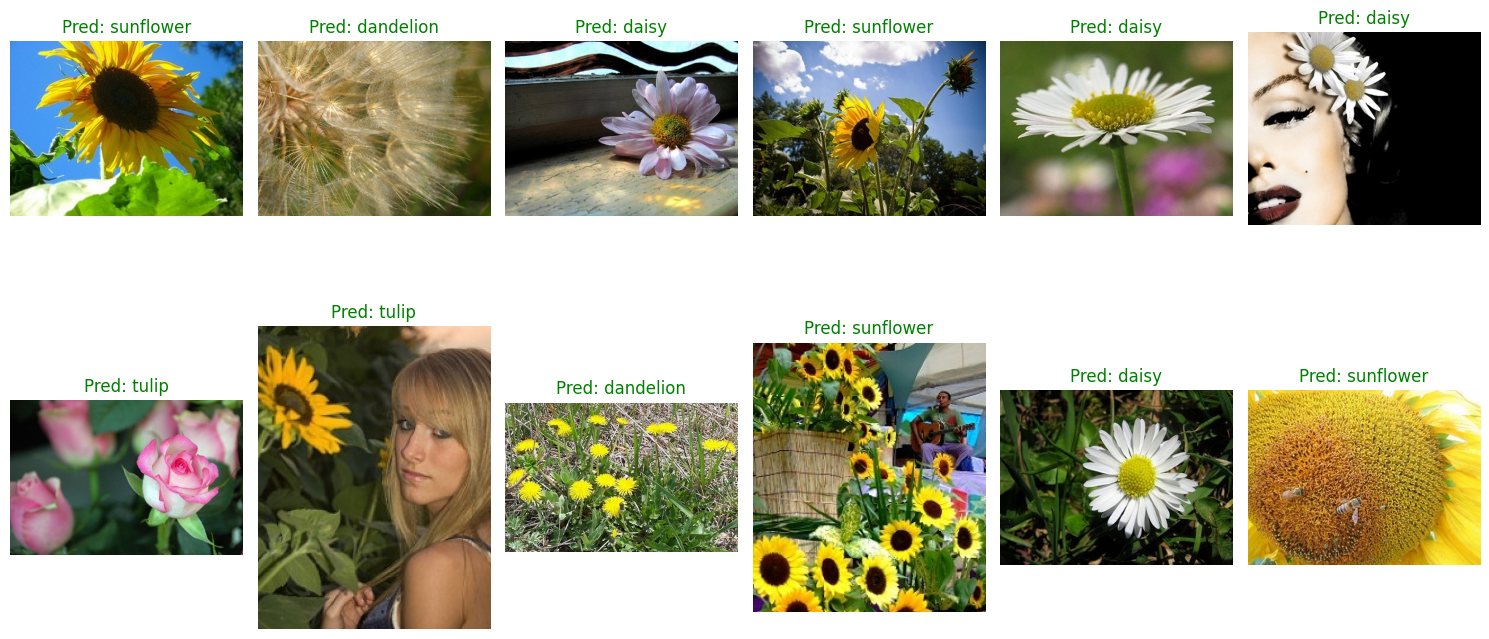

In [70]:
show_predictions(df, num_images=12)

Save to CSV

In [72]:
df.to_csv("predictions.csv")

### End of Training